## Imports

In [ ]:
import torch
import os
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torchvision import transforms, models
from xml.dom import minidom
from bs4 import BeautifulSoup
from PIL import Image
from matplotlib import pyplot as plt
import cv2


## Dataset

In [2]:
xml_example='./dataset/annot/cat.0.xml'
with open(xml_example, 'r') as f:
    data=f.read()
    content=BeautifulSoup(data, 'xml')
    
content

<?xml version="1.0" encoding="utf-8"?>
<annotation verified="yes">
<folder>Annotation</folder>
<filename>cat.0.jpg</filename>
<path>Cat-PascalVOC-export/Annotations/cat.0.jpg</path>
<source>
<database>Unknown</database>
</source>
<size>
<width>256</width>
<height>256</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>cat</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>55.35820533192091</xmin>
<ymin>10.992090947210452</ymin>
<xmax>197.38757944915255</xmax>
<ymax>171.24521098163842</ymax>
</bndbox>
</object>
</annotation>

In [3]:
def extract_xml_data(images_dir ,annot_file):
    xml_file = minidom.parse(annot_file)

    xmin = xml_file.getElementsByTagName('xmin')
    x1 = float(xmin[0].firstChild.data) 

    ymin = xml_file.getElementsByTagName('ymin')
    y1 = float(ymin[0].firstChild.data) 

    xmax = xml_file.getElementsByTagName('xmax')
    x2 = float(xmax[0].firstChild.data)

    ymax = xml_file.getElementsByTagName('ymax')
    y2 = float(ymax[0].firstChild.data) 

    class_name = xml_file.getElementsByTagName('name')

    if class_name[0].firstChild.data == "cat":
        class_num = 0
    else:
        class_num = 1

    image_file = xml_file.getElementsByTagName('filename')
    image_name = image_file[0].firstChild.data

    image_path = os.path.join(images_dir, image_name)
    image = Image.open(image_path)
    image_size = image.size
    

    return image_name, class_num, x1 / image_size[0], y1 / image_size[1], x2 / image_size[0], y2 / image_size[1]



In [4]:
def xml_to_csv():
    annots_list = []

    images_dir = 'dataset/images/'
    annots_dir = 'dataset/annot/'

    xml_files_name = os.listdir(annots_dir)

    for xml_name in xml_files_name:
        xml_path = os.path.join(annots_dir, xml_name)
        annot = extract_xml_data(images_dir ,xml_path)

        annots_list.append(annot)
    
    annots_columns = ['image_name', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
    annots_df = pd.DataFrame(annots_list, columns=annots_columns)

    return annots_df

    

In [5]:
labels_annots = xml_to_csv()
labels_annots

,image_name,label,xmin,ymin,xmax,ymax
0,cat.0.jpg,0,0.216243,0.042938,0.771045,0.668927
1,cat.1.jpg,0,0.193644,0.094915,1.000000,1.000000
2,cat.10.jpg,0,0.039972,0.101695,1.000000,1.000000
3,cat.100.jpg,0,0.113418,0.040678,0.912288,1.000000
4,cat.101.jpg,0,0.065960,0.041808,1.000000,1.000000
...,...,...,...,...,...,...
1195,dog.9076.jpg,1,0.171328,0.115819,0.531073,0.339266
1196,dog.9077.jpg,1,0.253531,0.081356,0.783898,1.000000
1197,dog.9078.jpg,1,0.258051,0.080226,0.777825,0.919774
1198,dog.9079.jpg,1,0.012853,0.016949,1.000000,0.956215


In [6]:
labels_annots.to_csv('./dataset/labrl_annot_dataset.csv', index=False)

In [7]:
class ImageDataset(Dataset):

    def __init__(self, data_dir, csv_name, transformer=None):
        self.data_dir = data_dir
        self.csv_path = os.path.join(self.data_dir, csv_name)
        self.csv_file = pd.read_csv(self.csv_path)
        self.transformer = transformer
        self.len = self.csv_file.shape[0]

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, 'images', self.csv_file.iloc[idx, 0])
        image = Image.open(image_path)

        label = float(self.csv_file.iloc[idx, 1])
        
        xmin = float(self.csv_file.iloc[idx, 2])
        ymin = float(self.csv_file.iloc[idx, 3])
        xmax = float(self.csv_file.iloc[idx, 4])
        ymax = float(self.csv_file.iloc[idx, 5])

        if self.transformer:
            image = self.transformer(image)

        return image, torch.tensor([label]), torch.tensor([xmin, ymin, xmax, ymax])

    def __len__(self):
        return self.len
        

In [8]:
train_transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ColorJitter(brightness=(0.5,1), contrast=0.5,saturation=0, hue=0.1,),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0,0,0], std=[1,1,1])
                                    ])

In [9]:
valid_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0,0,0], std=[1,1,1])
                                    ])

In [10]:
train_dataset = ImageDataset(data_dir='dataset', csv_name='labrl_annot_dataset.csv', transformer=train_transform)
valid_dataset = ImageDataset(data_dir='dataset', csv_name='labrl_annot_dataset.csv', transformer=valid_transform)

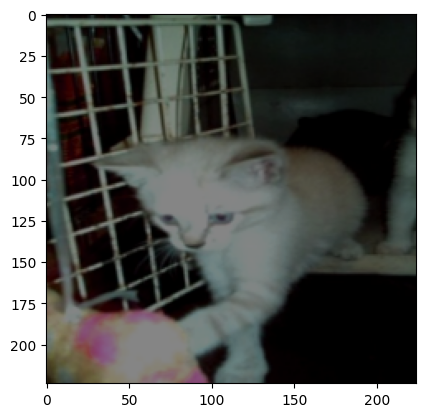

In [11]:
plt.imshow(train_dataset[120][0].permute(1, 2, 0))

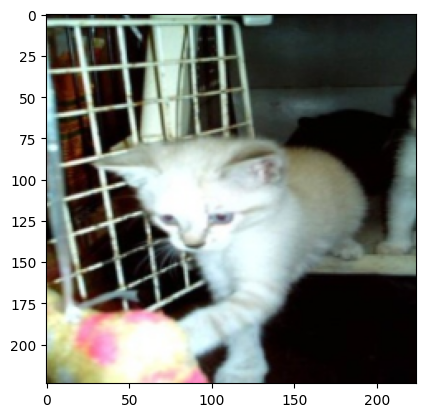

In [12]:
plt.imshow(valid_dataset[120][0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

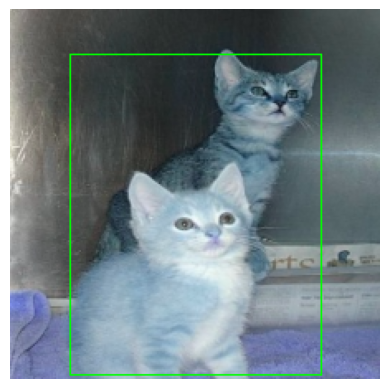

In [33]:
x1 = train_dataset[190][2][0] * 224
x2 = train_dataset[190][2][2] * 224
y1 = train_dataset[190][2][1] * 224
y2 = train_dataset[190][2][3] * 224

# The image to visualize
image = valid_dataset[190][0].permute(1, 2, 0)
image = np.asarray(image)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# Draw bounding boxes on the image
cv2.rectangle(image, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0),1)
    
plt.imshow(image)
plt.axis('off')

In [14]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=16, shuffle=True)

## Model

In [15]:
pre_trained_model = models.vgg16(pretrained=True)

E:\pytorch-course\torchenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\pytorch-course\torchenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
pre_trained_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
for param in pre_trained_model.parameters():
    param.requires_grad = False

In [18]:
last_layer_in_features =  pre_trained_model.classifier[6].in_features
last_layer_in_features

4096

In [19]:
pre_trained_model.classifier = nn.Sequential(*list(pre_trained_model.classifier.children())[:-1])
pre_trained_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
class LocalizationModel(nn.Module):
    
    def __init__(self, pre_trained_model, last_layer_in_features, out_features):
        super().__init__()
        self.pretrained_part = pre_trained_model
        self.class_out = nn.Linear(in_features=last_layer_in_features, out_features=out_features)
        self.bbox_out = nn.Linear(in_features=last_layer_in_features, out_features=4)

    def forward(self, x):
        x = self.pretrained_part(x)
        class_label = torch.sigmoid(self.class_out(x))

        bbox = self.bbox_out(x)

        return class_label, bbox

In [21]:
final_model = LocalizationModel(pre_trained_model, last_layer_in_features, 1)

In [22]:
final_model

LocalizationModel(
  (pretrained_part): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplac

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [24]:
final_model.to(device=device)

LocalizationModel(
  (pretrained_part): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplac

## Train

In [25]:
optimizer = optim.Adam(final_model.parameters(), lr=0.001)

In [26]:
classificatio_loss = nn.BCELoss()
bbox_loss = nn.MSELoss()

In [27]:
def train(train_loader, valid_loader, optimizer, class_loss, bbox_loss, epochs, model, device, data_length):
    valid_losses = []
    valid_accuracies = []

    for epoch in range(epochs):
        tot_loss = 0
        tot_correct = 0

        model.train()

        for (x, y, z) in train_loader:
            x = x.to(device)
            y = y.to(device)
            z = z.to(device)

            y_hat, z_hat = model(x)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                class_l = class_loss(y_hat, y)
                bbox_l = bbox_loss(z_hat, z)
                (bbox_l + class_l).backward()
                optimizer.step()


        model.eval()

        for (x_val , y_val, z_val) in valid_loader:
        	
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            z_val =  z_val.to(device)
          
            y_val_hat,z_val_hat= model(x_val)
                
            class_l_val = class_loss(y_val_hat, y_val)
            bbox_l_val = bbox_loss(z_val_hat, z_val)

            pred_labels = torch.tensor([1 if y_val_hat[l]>=0.5 else 0 for l in range(y_val_hat.shape[0])]).view(-1, 1).to(device)
           
            tot_correct += torch.sum(y_val== pred_labels)
            tot_loss += (class_l + bbox_l)
        
        
        print(f'epoch {epoch}: validation_loss: {tot_loss}')
        print(f'epoch {epoch}: validation_accuracy: {tot_correct / data_length}')

        valid_losses.append(tot_loss.item())
        valid_accuracies.append((tot_correct / data_length).item())

    
    
    print(f'all_epochs_acc: {valid_accuracies} \nall_epochs_loss: {valid_losses}')


In [28]:
data_length = len(train_dataset)

train(train_loader=train_loader,\
     valid_loader=valid_loader,\
         optimizer=optimizer,\
             class_loss=classificatio_loss,\
                 bbox_loss=bbox_loss, epochs=30,\
                     model=final_model, device=device,\
                        data_length=data_length)

epoch 0: validation_loss: 33.83360290527344
epoch 0: validation_accuracy: 0.9508333802223206
epoch 1: validation_loss: 15.045136451721191
epoch 1: validation_accuracy: 0.9608333706855774
epoch 2: validation_loss: 18.482927322387695
epoch 2: validation_accuracy: 0.9700000286102295
epoch 3: validation_loss: 15.438780784606934
epoch 3: validation_accuracy: 0.9741666913032532
epoch 4: validation_loss: 20.415443420410156
epoch 4: validation_accuracy: 0.9766666889190674
epoch 5: validation_loss: 8.615606307983398
epoch 5: validation_accuracy: 0.9783333539962769
epoch 6: validation_loss: 22.130598068237305
epoch 6: validation_accuracy: 0.9825000166893005
epoch 7: validation_loss: 24.854124069213867
epoch 7: validation_accuracy: 0.9808333516120911
epoch 8: validation_loss: 25.16651725769043
epoch 8: validation_accuracy: 0.98416668176651
epoch 9: validation_loss: 28.58101463317871
epoch 9: validation_accuracy: 0.9850000143051147
epoch 10: validation_loss: 15.858935356140137
epoch 10: validation

## Validation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class: dog


(-0.5, 223.5, 223.5, -0.5)

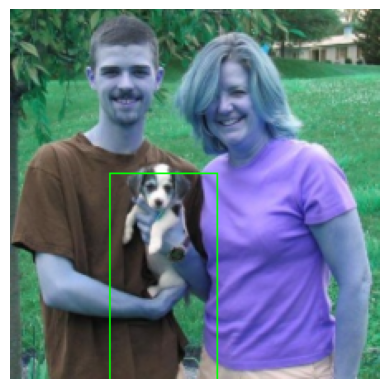

In [45]:
image = valid_dataset[899][0]
image = torch.reshape(image, (1, 3, 224, 224))
y_pred, bbox = final_model(image.to(device))
label = 'cat' if y_pred<=0.5 else 'dog'
print(f'class: {label}')

x1 = bbox[0][0] * 224
x2 = bbox[0][2] * 224
y1 = bbox[0][1] * 224
y2 = bbox[0][3] * 224

image = torch.reshape(image, (3, 224, 224))
image =image.permute(1, 2, 0)
image = np.asarray(image)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

cv2.rectangle(image, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0),1)
    
plt.imshow(image)
plt.axis('off')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class: dog


(-0.5, 223.5, 223.5, -0.5)

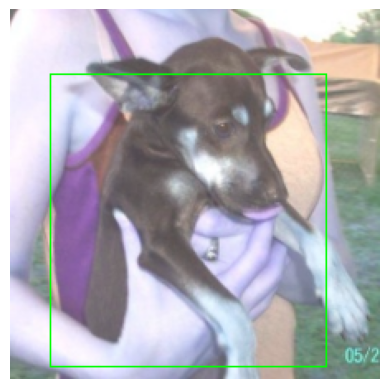

In [49]:
image = valid_dataset[989][0]
image = torch.reshape(image, (1, 3, 224, 224))
y_pred, bbox = final_model(image.to(device))
label = 'cat' if y_pred<=0.5 else 'dog'
print(f'class: {label}')

x1 = bbox[0][0] * 224
x2 = bbox[0][2] * 224
y1 = bbox[0][1] * 224
y2 = bbox[0][3] * 224

image = torch.reshape(image, (3, 224, 224))
image =image.permute(1, 2, 0)
image = np.asarray(image)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

cv2.rectangle(image, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0),1)
    
plt.imshow(image)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class: cat


(-0.5, 223.5, 223.5, -0.5)

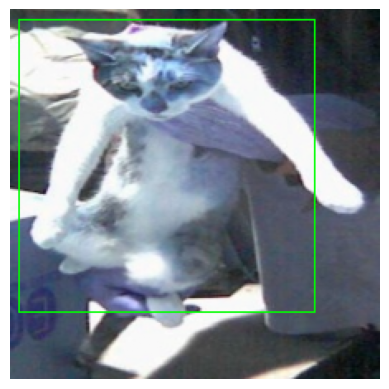

In [51]:
image = valid_dataset[26][0]
image = torch.reshape(image, (1, 3, 224, 224))
y_pred, bbox = final_model(image.to(device))
label = 'cat' if y_pred<=0.5 else 'dog'
print(f'class: {label}')

x1 = bbox[0][0] * 224
x2 = bbox[0][2] * 224
y1 = bbox[0][1] * 224
y2 = bbox[0][3] * 224

image = torch.reshape(image, (3, 224, 224))
image =image.permute(1, 2, 0)
image = np.asarray(image)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

cv2.rectangle(image, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0),1)
    
plt.imshow(image)
plt.axis('off')